# Define PANORAMIC fields

The associations have been computed in `step1-define-associations.ipynb` and the preprocessing executed elsewhere....


In [1]:
import os
os.chdir('../Mosaics')

In [2]:
! head -1 p3990_fields.txt
! cat p3990_fields.txt | sort -k 9

# field        n   sx    sy   ra         dec         nx  ny  date       time
j205832m4247 180   6.0   7.9 314.635160  -42.787775  5   6  2023-10-16 09:42:16.799
j231628m5910 296   6.6   7.4 349.116880  -59.160376  5   6  2023-10-18 01:43:18.315
j001420m3025  60   6.5   6.1   3.586531  -30.415215  5   5  2023-10-29 19:23:44.808
j221732p0009  80   4.7   6.7 334.381165    0.147688  4   5  2023-11-08 01:39:10.472
j033212m2749  80   6.6   3.7  53.044526  -27.812368  5   3  2023-11-19 20:05:34.733
j050148m4338 120   6.6   4.5  75.457473  -43.631918  5   4  2023-11-26 06:27:20.082
j033216m2750  40   6.7   5.2  53.085812  -27.882649  5   4  2023-12-06 17:50:55.068
j023016m0517  40   6.0   6.6  37.571289   -5.277156  5   5  2023-12-09 20:34:00.247
j021700m0504 180  13.1   7.3  34.243730   -5.069439 10   6  2023-12-23 18:58:15.129
j021736m0427  40   5.5   6.7  34.404655   -4.452139  5   5  2023-12-24 09:41:41.047
j033212m2747 190   6.9   7.6  53.042680  -27.757337  6   6  2024-01-01 18:41:52.404

In [3]:
# Which mosaics have been made?
! cat p3990_mosaic_log.txt

# field  version date time 
j044644m2637  v7.2  2024-02-22 16:56:52.608
j205832m4247  v7.2  2024-02-23 10:05:00.371
j050148m4338  v7.2  2024-02-23 10:48:53.244
j001420m3025  v7.2  2024-02-23 14:05:55.770


In [4]:
import os
import gc
import glob

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

import astropy.io.fits as pyfits
import astropy.wcs as pywcs
import astropy.time

from grizli.aws import db, visit_processor
from grizli import utils, prep
from grizli.pipeline import auto_script

from mastquery import overlaps

In [5]:
def create_s3_index(path, output_file="index.html", extra_html="", upload=True):
    """
    Create HTML listing of an S3 path
    """
    import time

    url = path.replace('s3://', 'https://s3.amazonaws.com/')

    lsfile = output_file.replace('.html','.ls')

    # Sort by filename
    sort_str = 'sort -k 4'

    os.system(f'aws s3 ls {path} | {sort_str} |grep -v PRE |grep -v {output_file} > {lsfile}')

    now = time.ctime()
    html=f"<h3>{now}</h3>\n"

    html += extra_html

    html += "\n<pre>\n"
    
    lines=open(lsfile).readlines()
    for line in lines:
        lsp = line.split()
        if len(lsp) == 4:
            html += "{0} {1} {2:>10} <a href={4}{3} > {3} </a>\n".format(*lsp, url)

    html += '</pre>\n'
    fp = open(output_file,'w')
    fp.write(html)
    fp.close()
    
    if upload:
        os.system(f'aws s3 cp {output_file} {path} --acl public-read')
        print(path.replace('s3://', 'https://s3.amazonaws.com/') + output_file)

    print(output_file)


## Query database for exposure footprints

In [6]:
# Query the grizli database for processed exposures
program_id = 3990

res = db.SQL(f"""select assoc, dataset, filter,
crval1 as ra, crval2 as dec, footprint as coords,
expstart as t_min, exptime, detector, instrume
from exposure_files where (dataset like 'jw{program_id:05d}%%')""" 
)

len(res)


2426

In [7]:
# Compute general footprint for a given field based on NIRCam overlaps
if 0:
    # e.g., MACS0416
    
    ra, dec = 93.968, -57.781

    res = db.SQL(f"""select assoc, dataset, filter,
crval1 as ra, crval2 as dec, footprint as coords,
expstart as t_min, exptime, detector, instrume
from exposure_files where polygon(footprint) && polygon(circle(point({ra}, {dec}),0.5)) and instrume = 'NIRCAM'
""")
    
    res['parent'] = [a.split('_')[0] for a in res['assoc']]
    un = utils.Unique(res['parent'])
    res['parent'] = un.values[np.argmax(un.counts)]
    un = utils.Unique(res['parent'])
    

In [8]:
# Group by "parent" defined when associations were generated
res['parent'] = [a.split('_')[0] for a in res['assoc']]
res['parent-filt'] = [a.split('_')[0] + '-' + f
                      for a, f in zip(res['assoc'], res['filter'])]
       
# Split double field j224612m0527
test = res['parent'] == 'j224612m0527'
south = (res['dec'] < -5.4)
print((test & south).sum(), (test & ~south).sum())

parent = res['parent'].tolist()

for i in np.where(test & south)[0]:
    parent[i]= utils.radec_to_targname(res['ra'][test & south].mean(), res['dec'][test & south].mean())
for i in np.where(test & ~south)[0]:
    parent[i]= utils.radec_to_targname(res['ra'][test & ~south].mean(), res['dec'][test & ~south].mean())
    
res['parent'] = parent

# Merge MACS0416
dr = np.sqrt((res['ra']-64.061150)**2 +  (res['dec'] + 24.144900)**2)
macs0416 = dr < 0.4
if macs0416.sum() >  0:
    print(f"Merge {np.unique(res['parent'][macs0416]).tolist()} > 'j041616m2409'")
    res['parent'][macs0416] = 'j041616m2409'

# Merge 0138
dr = np.sqrt((res['ra'] - 24.453446)**2 +  (res['dec'] + 21.864537)**2)
mat = dr < 0.4
if mat.sum() >  0:
    print(f"Merge {np.unique(res['parent'][mat]).tolist()} > 'j013748m2152'")
    res['parent'][mat] = 'j013748m2152'

un = utils.Unique(res['parent'])

0 0
   N  value     
====  ==========
  20  j165448p6258
  40  j023016m0517
  40  j033216m2750
  40  j021736m0427
  60  j030508m3146
  60  j022556p0308
  60  j001420m3025
  80  j022428p0002
  80  j221732p0009
  80  j033212m2749
  90  j021656m0508
 120  j024024m0253
 120  j050148m4338
 180  j205832m4247
 180  j033212m2745
 180  j021700m0504
 190  j033212m2747
 240  j044644m2637
 270  j021652m0508
 296  j231628m5910


In [9]:
! rm p3990_fields.txt

# field        n   sx    sy   ra         dec         nx  ny  date       time
j001420m3025  60   6.5   6.1   3.586531  -30.415215  5   5  2023-10-29 19:23:44.808
j021652m0508 270  11.8   9.3  34.240568   -5.155616  9   7  2024-01-19 06:41:41.047
j021656m0508  90   5.3   6.7  34.221813   -5.148665  4   5  2024-01-21 05:43:22.329
j021700m0504 180  13.1   7.3  34.243730   -5.069439 10   6  2023-12-23 18:58:15.129
j021736m0427  40   5.5   6.7  34.404655   -4.452139  5   5  2023-12-24 09:41:41.047
j022428p0002  80   5.2   6.7  36.108917    0.038644  4   5  2024-01-14 15:25:40.025
j022556p0308  60   4.8   6.7  36.481934    3.129159  4   5  2024-01-26 03:37:17.295
j023016m0517  40   6.0   6.6  37.571289   -5.277156  5   5  2023-12-09 20:34:00.247
j024024m0253 120   4.9   6.7  40.098272   -2.875495  4   5  2024-01-26 09:39:23.999
j030508m3146  60   4.9   6.7  46.288799  -31.769892  4   5  2024-01-27 13:37:46.095
j033212m2745 180   5.7   6.7  53.059355  -27.753599  5   5  2024-01-20 01:49:09.707

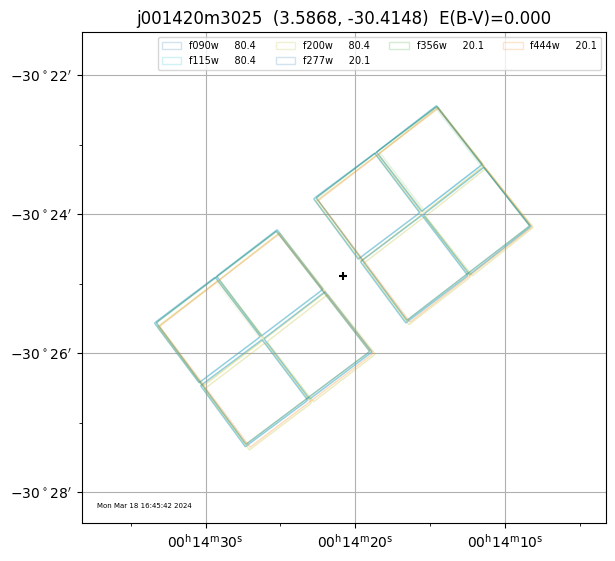

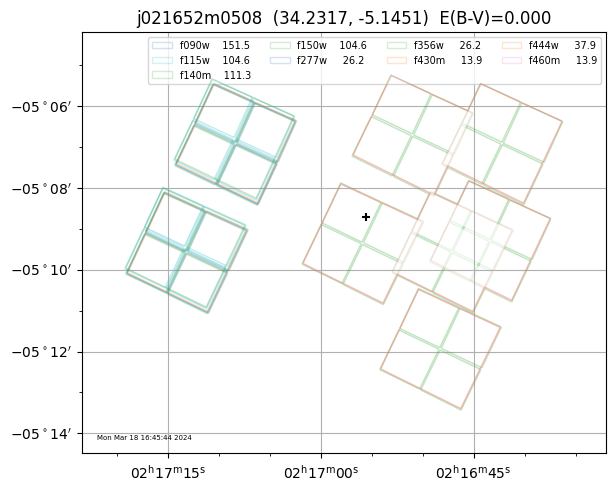

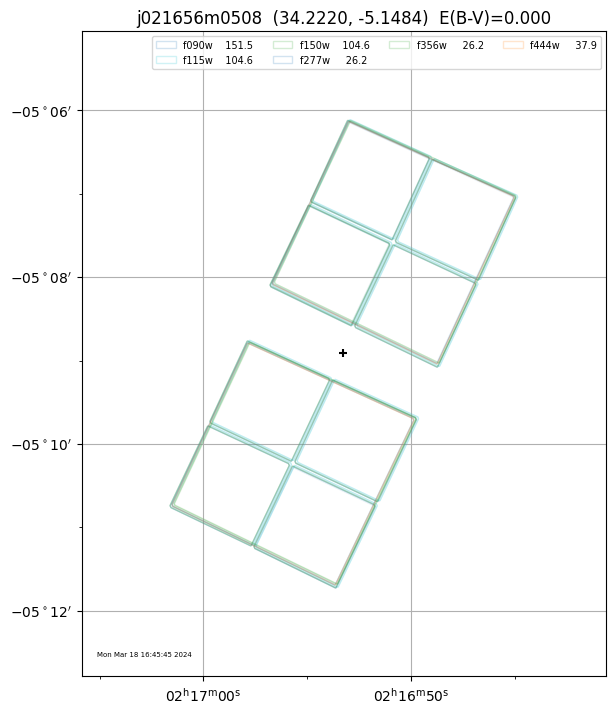

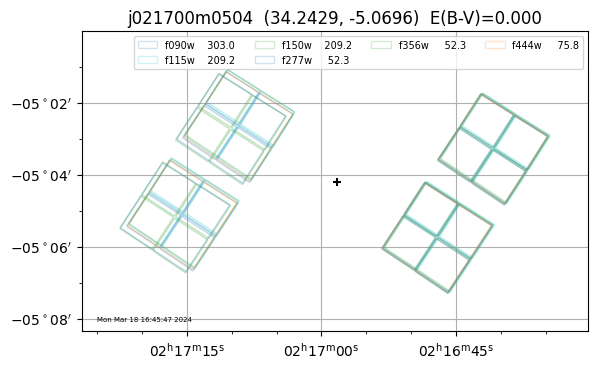

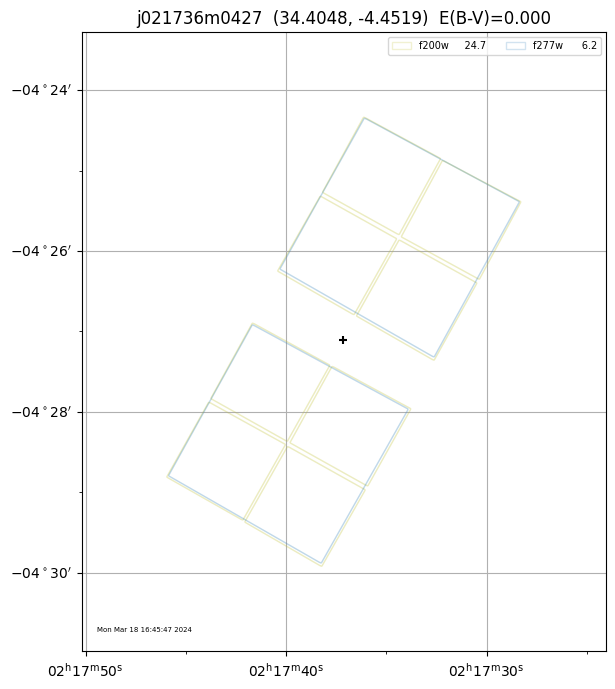

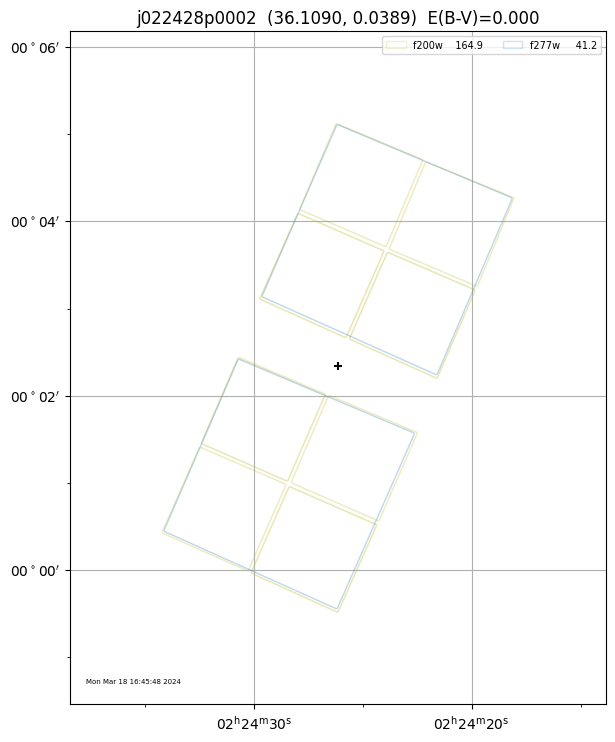

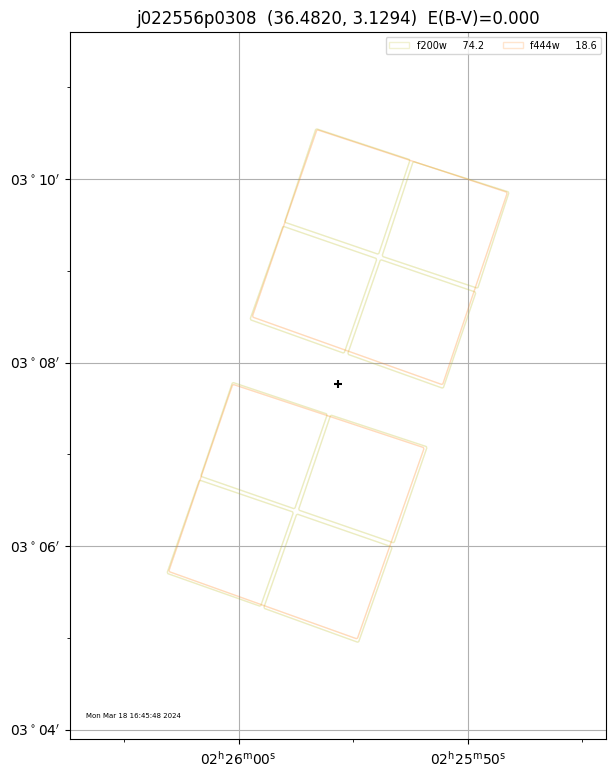

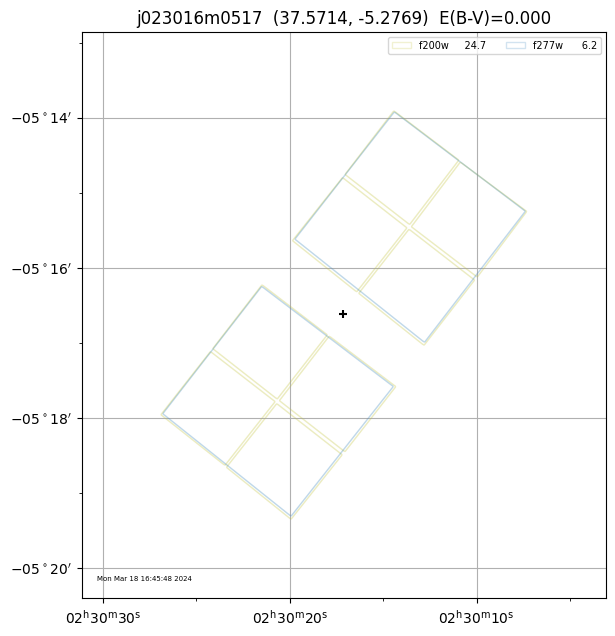

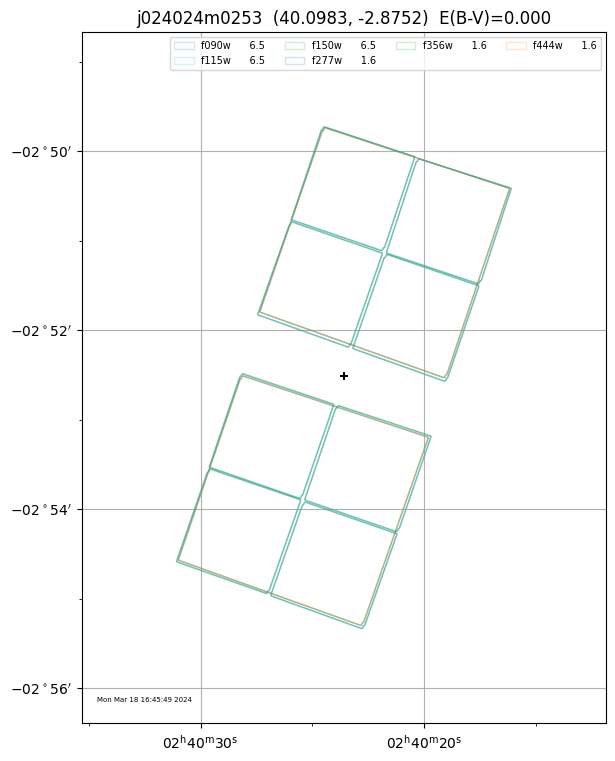

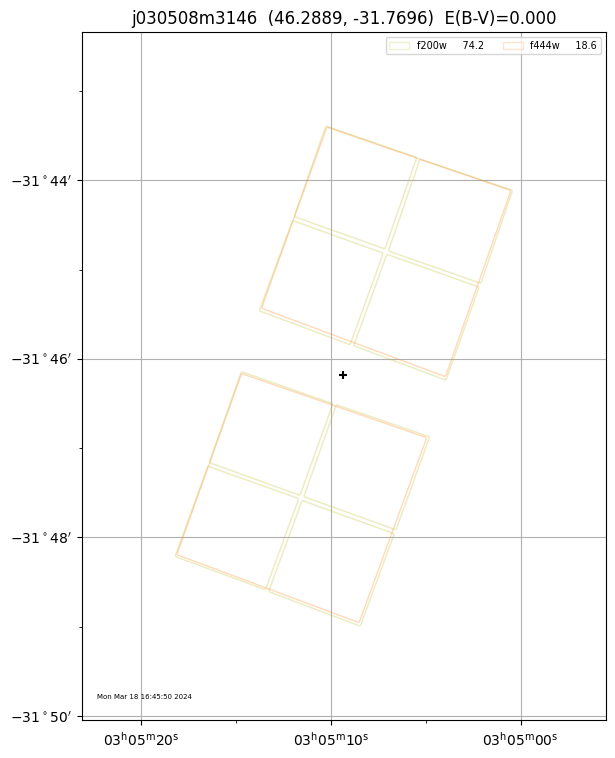

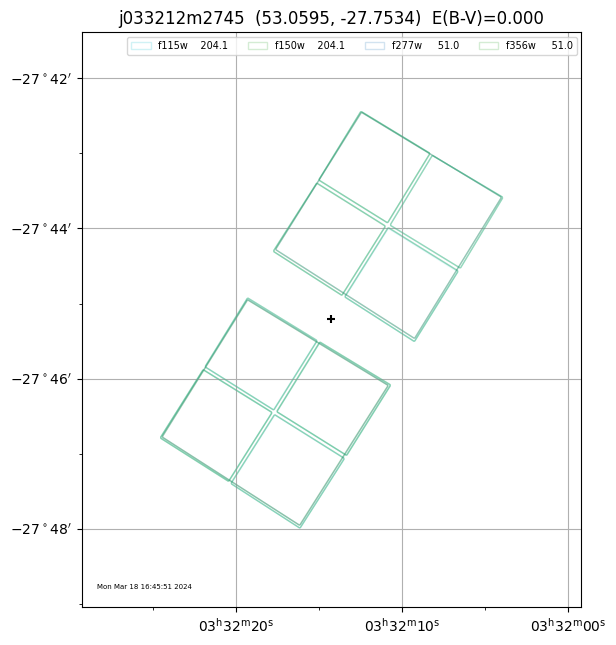

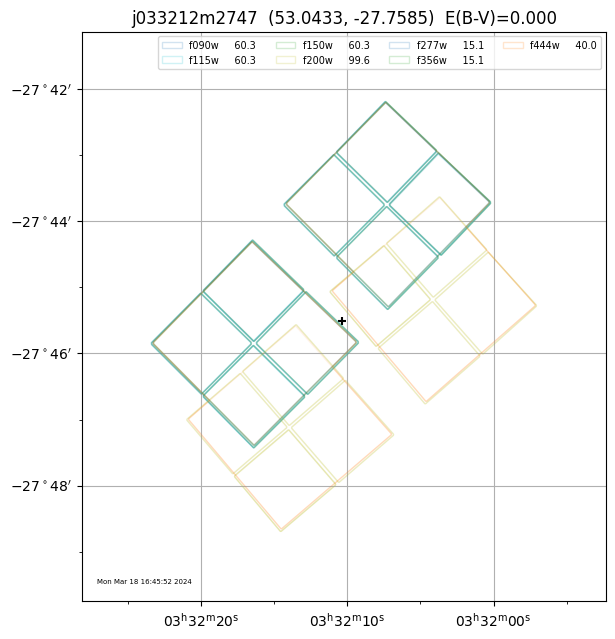

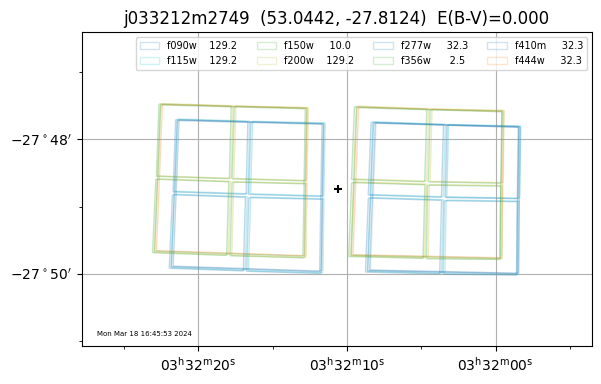

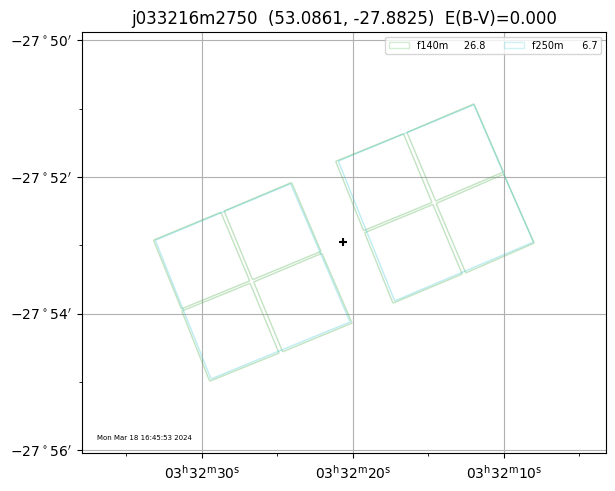

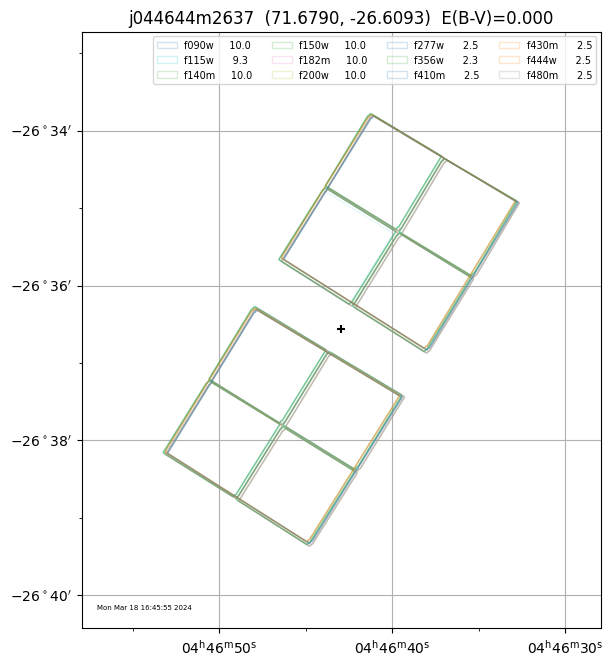

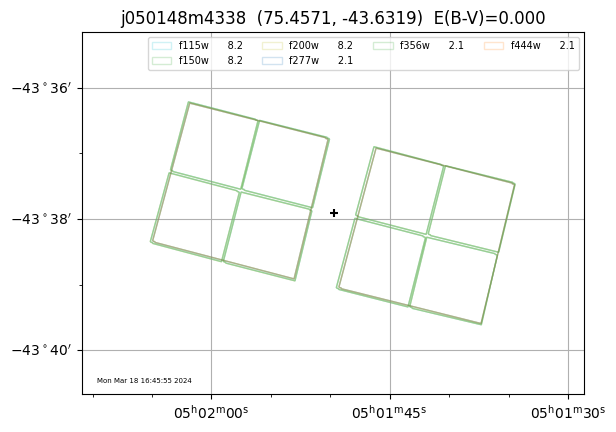

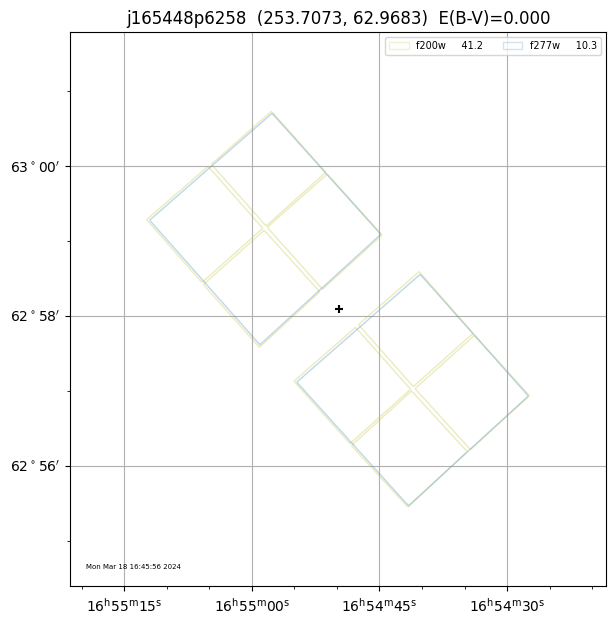

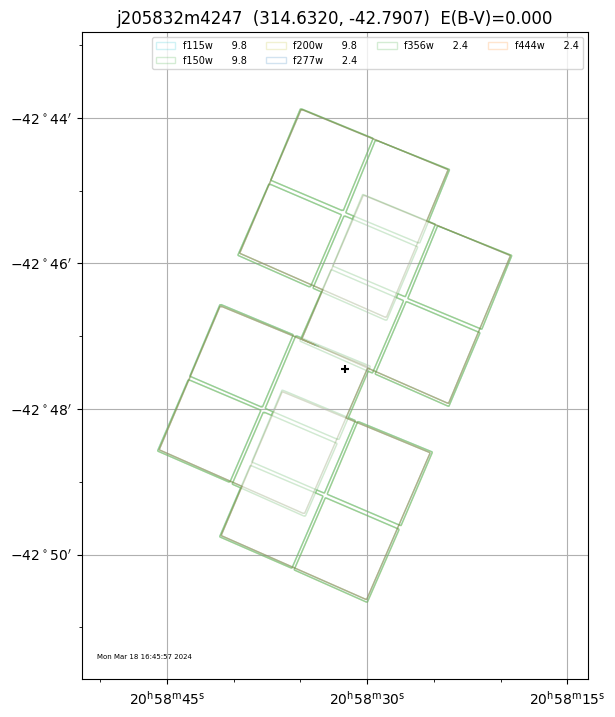

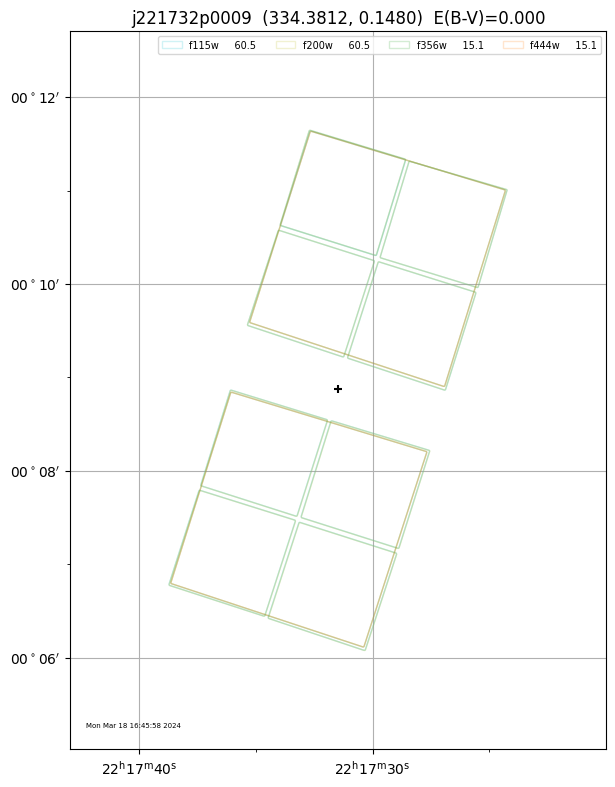

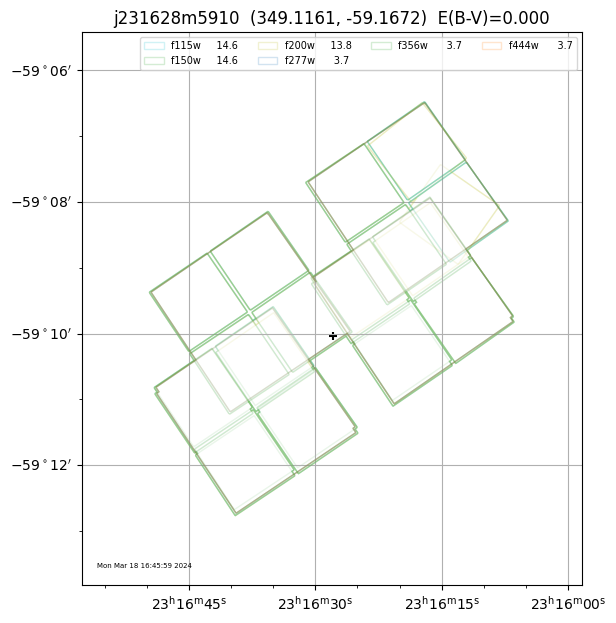

In [10]:
row = '# field        n   sx    sy   ra         dec         nx  ny  date       time'
with open('p3990_fields.txt','w') as fp:
    fp.write(row+'\n')

print(row)

for field in un.values:
    rf = res[un[field]]
    
    # Things needed for the plot script
    rf.meta['NAME'] = field
    rf.meta['RA'] = np.mean(rf['ra'])
    rf.meta['DEC'] = np.mean(rf['dec'])
    rf.meta['MW_EBV'] = 0.0
    
    rf['obs_id'] = rf['dataset']
    rf['proposal_id'] = [int(d[3:7]) for d in rf['dataset']]
    rf['t_max'] = rf['t_min'] + rf['exptime']/86400.
    rf['instrument_name'] = rf['instrume']
    rf['target'] = 'indef'
    rf['filter'] = [f.split('-')[0] for f in rf['filter']]
    rf['footprint'] = [f'POLYGON {f.replace("(","").replace(")","").replace(","," ")}'
                       for f in rf['coords']]

    _ = overlaps.split_associations(rf, assoc_min=0, 
                                        #assoc_args=assoc_args,
                                        force_split=True,
                                        with_ls_thumbnail=False,
                                        xsize=6,
                                        )
                                        #ls_args=LS_ARGS)
    
    tab = _[0]
    fig = _[1]
    fig.savefig(f'p3990-{field}.png')
    
    # size: the plot window is a box containing the exposures padded by 1arcmin
    cosd = np.cos(rf.meta['DEC']/180*np.pi)
    sx = (rf.meta['XMAX'] - rf.meta['XMIN'])*cosd*60-1
    sy = (rf.meta['YMAX'] - rf.meta['YMIN'])*60-1
    
    # Center of the plot as center ra/dec
    ra0 = (rf.meta['XMAX'] + rf.meta['XMIN'])/2.
    de0 = (rf.meta['YMAX'] + rf.meta['YMIN'])/2.
    
    # Size in units of 2048 x 40mas/pixel 
    nx = int(np.ceil(sx/(2048*0.04/60)))
    ny = int(np.ceil(sy/(2048*0.04/60)))

    tmax = astropy.time.Time(rf['t_max'].max(), format='mjd').iso

    row = f"{field:12} {un[field].sum():>3} {sx:5.1f} {sy:5.1f} {ra0:10.6f}  {de0:10.6f} {nx:>2}  {ny:>2}  {tmax}"
    if 1:
        with open('p3990_fields.txt','a') as fp:
            fp.write(row+'\n')

    print(row)

## Run mosaics, catalogs

In [11]:
fields = utils.read_catalog('p3990_fields.txt')
so = np.argsort(fields['date'])

fields[so].to_pandas()

,field,n,sx,sy,ra,dec,nx,ny,date,time
0,j205832m4247,180,6.0,7.9,314.635160,-42.787775,5,6,2023-10-16,09:42:16.799
1,j231628m5910,296,6.6,7.4,349.116880,-59.160376,5,6,2023-10-18,01:43:18.315
2,j001420m3025,60,6.5,6.1,3.586531,-30.415215,5,5,2023-10-29,19:23:44.808
3,j221732p0009,80,4.7,6.7,334.381165,0.147688,4,5,2023-11-08,01:39:10.472
4,j033212m2749,80,6.6,3.7,53.044526,-27.812368,5,3,2023-11-19,20:05:34.733
5,j050148m4338,120,6.6,4.5,75.457473,-43.631918,5,4,2023-11-26,06:27:20.082
6,j033216m2750,40,6.7,5.2,53.085812,-27.882649,5,4,2023-12-06,17:50:55.068
7,j023016m0517,40,6.0,6.6,37.571289,-5.277156,5,5,2023-12-09,20:34:00.247
8,j021700m0504,180,13.1,7.3,34.243730,-5.069439,10,6,2023-12-23,18:58:15.129
9,j021736m0427,40,5.5,6.7,34.404655,-4.452139,5,5,2023-12-24,09:41:41.047


In [12]:
# Set version

#mosaic_version = 'v6.0' # latest grizli (May 2023)

mosaic_version = 'v7.2' # 2024 version with snowblind masking

In [13]:
os.path.exists('/workspaces/panoramic-jwst')

False

In [14]:
# Work in /scratch on the root filesystem if expect to make more than 5 GB of files.
# NB: files here won't be saved when the machine is shut down!

# hmm, but doesn't seem to work
if 0:
    work_path = '/scratch'
    if not os.path.exists(work_path):
        os.makedirs(work_path)
elif os.path.exists('/workspaces/panoramic-jwst'):
    work_path = '/workspaces/panoramic-jwst/Mosaics'
else:
    for work_path in ['/GrizliImaging','/work','/tmp']:
        if os.path.exists(work_path):
            break

os.chdir(work_path)
print(f'Working directory: {work_path}')

! df -h . 

Working directory: /GrizliImaging
Filesystem      Size  Used Avail Use% Mounted on
/dev/nvme1n1    367G   69M  348G   1% /GrizliImaging


In [15]:
fields_to_run = ['j033212m2747']#j001420m3025 is overlapping ABELL2744 
# Already completed:
#j050148m4338'] #j205832m4247'] 
#REDO THIS WITH FULL FILTER SET: ['j044644m2637']


In [16]:
# RGB mosaic
def make_rgb(root, full_dimensions=2, scl=2.0):
    """
    Make RGB image
    """

    files = glob.glob(f"{root}*-f*clear*sci.fits*")
    files.sort()    

    filters = [f.split('-')[-2] + '-clear' for f in files]
    filters.sort()
    print(filters)

    auto_script.IMSAVE_QUALITY = 99

    norm = {'stretch': 'asinh', 'min_cut': -0.01, 
                                            'max_cut': 5.0, 'clip':True, 
                                            'asinh_a':0.010}

    print({root})
    im = pyfits.open(files[-1])

    msk = im[0].data != 0
    yp , xp = np.indices(msk.shape)
    spad = 64
    xyslice = (slice(np.maximum(xp[msk].min()-spad, 0), xp[msk].max()+spad), 
                slice(np.maximum(yp[msk].min()-spad, 0), yp[msk].max()+spad))

    print('slice: ', xyslice)

    filts = ['f356w-clear','f150w-clear','f115w-clear']
    rgb_scl = [1.0, 0.95, 1.02]

    if 'f444w-clear' in filters:
        filts = ['f444w-clear','f277w-clear','f115w-clear']

    rgb = auto_script.field_rgb(root,
                            HOME_PATH=None, gzext='*', 
                            filters=filts,
                            force_rgb=filts,
                            rgb_scl=rgb_scl,
                            full_dimensions=full_dimensions,
                            scl=scl,
                            suffix='.rgb',
                            xsize=128,
                            xyslice=xyslice,
                            add_labels=False,
                            norm_kwargs=norm,
                            output_format='png',
                            fill_black=True,
                            pl=2.0, pf=1)

    plt.close('all')    

In [1]:
# Make a mosaic

LW_FILTERS = ['F277W-CLEAR','F356W-CLEAR','F444W-CLEAR',
              'F335M-CLEAR','F430M-CLEAR','F410M-CLEAR','F460M-CLEAR','F480M-CLEAR']

SW_FILTERS = ['F070W-CLEAR','F090W-CLEAR', 'F115W-CLEAR','F140M-CLEAR',
              'F150W-CLEAR','F182M-CLEAR','F200W-CLEAR', 'F210M-CLEAR' ]

WFC3IR_FILTERS = []#['F160W','F140W','F125W','F110W','F105W','F098M']

ACS_FILTERS = []#['F850LP','F814W','F606W','F435W','F438W','F775W']

SNOWBLIND_KWARGS = dict(new_jump_flag=1024,
                        min_radius=6, # 4 takes forever with udeep exposures
                        growth_factor=1.5, unset_first=True)

# Skip SW
#SW_FILTERS = []
# Skip HST
#WFC3IR_FILTERS = ACS_FILTERS = []

for field in fields_to_run:
    
    ix = np.where(fields['field'] == field)[0][0]

    pixel_scale = 0.04 # arcsec/pix

    hdu = utils.make_wcsheader(fields['ra'][ix], fields['dec'][ix],
                               size=(fields['nx'][ix]*2048*pixel_scale,
                                     fields['ny'][ix]*2048*pixel_scale),
                               pixscale=0.04, get_hdu=True)

    
    ir_wcs = pywcs.WCS(hdu.header)
    
    # Pull files from AWS and drizzle into a mosaic
    # NB: this will pull *any* exposure that overlaps with the defined WCS, 
    #     not just PANORAMIC from the query above. 

    root = f'p3990-{field}-{mosaic_version}'
    for filt in LW_FILTERS:
        _ = visit_processor.cutout_mosaic(rootname=root,
                                          ir_wcs=ir_wcs,
                                          clean_flt=True,
                                          filters=[filt],
                                          half_optical=False,
                                          s3output=None,
                                          pixfrac=0.75,
                                          kernel='square',
                                          weight_type='jwst',
                                          skip_existing=True,
                                          snowblind_kwargs=SNOWBLIND_KWARGS,
                                          make_exptime_map=True,
                                          expmap_sample_factor=4,
                                          keep_expmap_small=True,
                                          extra_query="AND dataset like 'jw03990%%' OR dataset like 'jw02514%%'",
                                      )
        gc.collect()
        ! gzip {root}*{filt.lower()}*fits

    # SW run in a slightly weird way for memory issues?
    for filt in SW_FILTERS:
        _ = visit_processor.cutout_mosaic(rootname=root,
                                          ir_wcs=ir_wcs,
                                          clean_flt=True,
                                          filters=[filt],
                                          half_optical=True,
                                          s3output=None,
                                          pixfrac=0.75,
                                          kernel='square',
                                          weight_type='jwst',
                                          skip_existing=True,
                                          snowblind_kwargs=SNOWBLIND_KWARGS,
                                          make_exptime_map=True,
                                          expmap_sample_factor=4,
                                          keep_expmap_small=True,
                                          extra_query="AND (dataset like 'jw03990%%' OR dataset like 'jw02514%%')",
                                      )
        gc.collect()
        ! gzip {root}*{filt.lower()}*fits

    # HST at 40mas, just in case
    for filt in WFC3IR_FILTERS + ACS_FILTERS:
        _ = visit_processor.cutout_mosaic(rootname=root,
                                          ir_wcs=ir_wcs,
                                          clean_flt=True,
                                          filters=[filt],
                                          half_optical=False,
                                          s3output=None,
                                          pixfrac=0.75,
                                          kernel='square',
                                          skip_existing=True,
                                          weight_type='median_err',
                                          make_exptime_map=True,
                                          expmap_sample_factor=4,
                                          keep_expmap_small=True,
                                      )
        
    #if (not os.path.exists(f'{root}.rgb.png')):
    #    make_rgb(root, full_dimensions=2, scl=2.0)


NameError: name 'fields_to_run' is not defined

In [ ]:
print(breakx)

### RGB image

In [ ]:
root = f'p3990-{field_to_run}-{mosaic_version}'
print(root)

In [ ]:
if True: # Not enough memory on GitHub/codespace
    if (not os.path.exists(f'{root}.rgb.png')):
        make_rgb(root, full_dimensions=2, scl=2.0)
    else:
        print('RGB image found')
else:
    print('Not making RGB images....')


### Detection image and catalog

LW detection image weighted by constant Fnu

Photometric catalog tends to run out of disk space...


In [ ]:
from grizli.pipeline import auto_script
from grizli import prep
import astropy.io.fits as pyfits

comb = {'ir':['F444W-CLEAR','F356W-CLEAR','F277W-CLEAR',
              'F430M-CLEAR','F460M-CLEAR','F480M-CLEAR', 
              'CLEARP-F277W','CLEARP-F356W', 'CLEARP-F444W']}

block_filters = ['F090W-CLEAR','F115W-CLEAR','F150W-CLEAR','F200W-CLEAR']

# Not enough memory on GitHub/codespace?
MAKE_CATALOG = True

for field in fields['field']:
    root = f'p3990-{field}-{mosaic_version}'

    files = glob.glob(f'{root}*sci.fits*')
    if len(files) == 0:
        continue
    
    if len(glob.glob(f'{root}-ir_drc_sci.fits*')) == 0:
        status = auto_script.make_filter_combinations(root,
                                                  filter_combinations=comb, 
                                                  weight_fnu=2, 
                                                  force_photfnu=1.e-8,
                                                  block_filters=block_filters
                                                 )
    
    # Make the photometric catalog
    phot_apertures = prep.SEXTRACTOR_PHOT_APERTURES_ARCSEC[:4]
    
    # Skip catalogs for now, since they make "bkg" images that fill up the disk quota
    if (not os.path.exists(f'{root}_phot.fits')) & MAKE_CATALOG:
        try:
            auto_script.multiband_catalog(field_root=root, 
                                      threshold=1.2, 
                                      bkg_params={'bw': 50, 'bh': 50,
                                                  'fw': 3, 'fh': 3,
                                                  'pixel_scale': pixel_scale}, 
                                      get_all_filters=True,
                                      phot_err_scale=1.0, 
                                      phot_apertures=phot_apertures,
                                      )
    
            phot = utils.read_catalog(f'{root}_phot.fits')
        except OSError:
            pass

        ! rm {root}*bkg.fits
        ! gzip {root}*seg.fits

In [ ]:
if False:

    if 0:
        db.execute("""delete from astrometry_reference
where src in ('j013748m2152_f444w_00043_cat', 'j013748m2152_f444w_00049_cat')
""")

    src = db.SQL("""select src, count(src) from astrometry_reference
    where circle(point(24.46, -21.86),0.3) @> point(ra,dec)
    group by src
    """)
    print(src)
    
    # Reference catalog for panoramic-j013748m2152-v7.2
    cat = utils.read_catalog('p3990-j013748m2152-v7.2_phot.fits')
    ok = (cat['flux_aper_1'] > 20*cat['fluxerr_aper_1']) & (cat['mask_aper_3'] == 0)
    ok &= cat['flux_radius'] < 10
    ok &= cat['mag_auto'] < 27
    corner = (cat['ra'] > 24.49) & (cat['dec'] < -21.90)
    ok &= ~corner
    
    #print(ok.sum())
    
    #plt.scatter(cat['mag_auto'][ok], cat['flux_radius'][ok], alpha=0.5)
    #plt.ylim(0, 20)
    plt.scatter(cat['ra'][ok], cat['dec'][ok], alpha=0.1, marker='.')

    cat['src'] = 'p3990-j013748m2152'
    if 0:
        db.send_to_database('astrometry_reference', cat['ra','dec','src'][ok], 
                        if_exists='append')

    

### Sync to S3

In [ ]:
import astropy.time

for field in fields['field']:
    root = f'p3990-{field}-{mosaic_version}'

    files = glob.glob(f'{root}*sci.fits*')
    if len(files) == 0:
        continue

    # Upload to S3
    ! rm {root}*bkg.fits

    files = glob.glob(f'{root}*_dr*fits')
    files += glob.glob(f'{root}*seg.fits')
    files.sort()
    
    for file in files:
        print(f'gzip {file}')
        ! gzip {file}

    s3path = f's3://grizli-panoramic/mosaics/{mosaic_version}/{field}/'

    ! aws s3 sync ./ {s3path} --exclude "*" --include "{root}*gz" --include "{root}*csv" --include "{root}*phot.fits" --include "{root}*cat.fits" --include "*{field}*png" --acl public-read

    extra_html = f"<img src=p3990-{field}.png height=400px> <img src={root}.rgb.png height=400px> \n<br>"

    filter_files = glob.glob(f'{root}*fp.png')
    filter_files.sort()
    for file in filter_files:
        extra_html += f"<img src={file} height=200px>\n"

    extra_html += "<pre>\n# filter  expstart  ndrizim  exptime\n"
    files = glob.glob(f'{root}-f*_dr*sci.fits.gz')
    files.sort()
    for file in files:
        with pyfits.open(file) as im:
            expfact = 1.
            if im[0].header['INSTRUME'] == 'NIRCAM':
                if im[0].header['DETECTOR'] in ['NRCALONG','NRCBLONG']:
                    expfact = 2
                else:
                    expfact = 8

            try:
                row = f"{im[0].header['FILTER']} {im[0].header['EXPSTART']:.2f}  {im[0].header['NDRIZIM']//expfact}  {im[0].header['EXPTIME']/expfact:.1f}"
            except:
                row = f"{im[0].header['FILTER1']} {im[0].header['FILTER2']} {im[0].header['EXPSTART']:.2f}  {im[0].header['NDRIZIM']//expfact}  {im[0].header['EXPTIME']/expfact:.1f}"

            print(row)
            extra_html += row + '\n'

    extra_html += f"</pre>\n"

    create_s3_index(s3path, output_file="index.html", extra_html=extra_html, upload=True)
    
    # Add to log
    log = utils.read_catalog('/home/ec2-user/telescopes/notebooks/panoramic-jwst/Mosaics/p3990_mosaic_log.txt')
    done = (log['field'] == field) & (log['version'] == mosaic_version)
    if done.sum() == 0:
        print(f'Add {field} {mosaic_version} to log.')

        with open('/home/ec2-user/telescopes/notebooks/panoramic-jwst/Mosaics/p3990_mosaic_log.txt','a') as fp:
            fp.write(f'{field}  {mosaic_version}  {astropy.time.Time.now().iso}\n')
    


## Master HTML log for all processed mosaics

Don't delete `mosaic_log.txt` if clearing out files to make space!

In [ ]:
! cat /home/ec2-user/telescopes/notebooks/panoramic-jwst/Mosaics/p3990_mosaic_log.txt

In [ ]:

log = utils.read_catalog('/home/ec2-user/telescopes/notebooks/panoramic-jwst/Mosaics/p3990_mosaic_log.txt')

un = utils.Unique(log['version'])

with open('mosaics_p3990.html','w') as fp:
    for v in un.values:
        fp.write(f'<h3> Version {v} </h3>\n')

        for i in np.where(un[v])[0]:
            s3 = f"https://s3.amazonaws.com/grizli-panoramic/mosaics/{v}/{log['field'][i]}/index.html"
            fp.write(f"{log['date'][i]} {log['time'][i]} <a href=\"{s3}\" /> {log['field'][i]} </a> <br> \n")

    fp.write(f'<h3> Fields </h3>\n')
    for field in fields['field']:
        fp.write(f'<p> {field} </p> <img src=p3990-{field}.png height=300px /> \n')

! aws s3 sync ./ s3://grizli-panoramic/mosaics/ --exclude "*" --include "mosaics_p3990.html" --include "p3990*png" --exclude "*fp.png" --acl public-read



In [ ]:
!df -h . 

In [ ]:
print(breakx)

# Summary HTML hosted on github pages

Make a markdown file that will be rendered at https://gbrammer.github.io/panoramic-jwst/Mosaics/summary


In [ ]:
from grizli.aws import db
# full = db.SQL("""select assoc, crval1 as ra, crval2 as dec, dataset, filter, detector, exptime, expstart from exposure_files
# where dataset like 'jw02514%%'
# order by assoc, filter""")

# full['parent'] = [a.split('_')[0] for a in full['assoc']]
       
# # Split double field j224612m0527
# test = full['parent'] == 'j224612m0527'
# south = (full['dec'] < -5.4)
# print((test & south).sum(), (test & ~south).sum())

# parent = full['parent'].tolist()

# for i in np.where(test & south)[0]:
#     parent[i]= utils.radec_to_targname(full['ra'][test & south].mean(), full['dec'][test & south].mean())
# for i in np.where(test & ~south)[0]:
#     parent[i]= utils.radec_to_targname(full['ra'][test & ~south].mean(), full['dec'][test & ~south].mean())
    
# full['parent'] = parent

# # Merge MACS0416
# dr = np.sqrt((full['ra']-64.061150)**2 +  (full['dec'] + 24.144900)**2)
# macs0416 = dr < 0.4
# if macs0416.sum() >  0:
#     print(f"Merge {np.unique(full['parent'][macs0416]).tolist()} > 'j041616m2409'")
#     full['parent'][macs0416] = 'j041616m2409'

# len(full)

In [ ]:
! aws s3 ls s3://grizli-panoramic/mosaics/v6.0/ > /tmp/v6.mosaic.txt
! aws s3 ls s3://grizli-panoramic/mosaics/v7.0/ > /tmp/v7.mosaic.txt
! aws s3 ls s3://grizli-panoramic/mosaics/v7.2/ > /tmp/v7.2.mosaic.txt

_, v6m = np.loadtxt('/tmp/v6.mosaic.txt', unpack=True, dtype=str)
_, v7m = np.loadtxt('/tmp/v7.mosaic.txt', unpack=True, dtype=str)
_, v72m = np.loadtxt('/tmp/v7.2.mosaic.txt', unpack=True, dtype=str)


In [ ]:
from grizli import utils
import numpy as np
import astropy.time
import time

# utils.Unique(full['filter'])
filters = np.unique(full['filter'])

with open('/home/ec2-user/telescopes/notebooks/panoramic-jwst/Mosaics/summary_bad.md','w') as fp:
    
    fp.write(f"""
![Alt text](../PanoramicLogo.png?raw=true "PanoramicLogo")

PANORAMIC Fields
----------------

- Exposure times in ks
- [Visit Status](https://www.stsci.edu/cgi-bin/get-visit-status?id=2514&markupFormat=html&observatory=JWST)

""")
    
    header    = '| field        | RA,Dec             | Note   | Date       '
    separator = '| :----------: | :----------------: | :----: | ----------:'
    for f in filters:
        header += f"| {f.split('-')[0]}  "
        separator += '|-------:'

    header += '|'
    separator += '|'
    print(header + '\n' + separator)

    fp.write(header + '\n' + separator + '\n')
    
    # prefix = [a.split('_')[0] for a in full['assoc']]
    # fields = utils.Unique(prefix, verbose=False)
    fields = utils.Unique(full['parent'], verbose=False)

    for fi in fields.values:
        fx = fields[fi]
        mjd = full['expstart'][fx].mean()
        iso = astropy.time.Time(mjd, format='mjd').iso.split()[0]

        
        row = f"| {fi} "
        if fi+'/' in v6m:
            row += f" [v6](https://s3.amazonaws.com/grizli-panoramic/mosaics/v6.0/{fi}/index.html) "
        if fi+'/' in v7m:
            row += f" [v7](https://s3.amazonaws.com/grizli-panoramic/mosaics/v7.0/{fi}/index.html) "
        if fi+'/' in v72m:
            row += f" [v7.2](https://s3.amazonaws.com/grizli-panoramic/mosaics/v7.2/{fi}/index.html) "

        ra_map = full['ra'][fx].mean()
        dec_map = full['dec'][fx].mean()

        note_text = ''

        if fi == 'j224604m0518':
            MAPURL = "https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/panoramic-j224612m0527/index.html?coord=341.517,-5.302"
            
        elif fi == 'j224616m0531':
            MAPURL = "https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/panoramic-j224612m0527/index.html?coord=341.565,-5.520"
            
        elif fi == 'j141932p5254':
            MAPURL = f"https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/egs-v2/index.html?coord={ra_map:.3f},{dec_map:.3f}"
            note_text = 'EGS'
            
        elif fi.startswith('j123') & ('p62' in fi):
            # elif fi == 'j123800p6217':
            MAPURL = "https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/gdn/jwst.html?coord=189.3994832,62.2906066"
            note_text = 'GDN'
            
        elif fi in ('j033236m2755'):
            note_text = 'GDS'
            MAPURL = f"https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/panoramic-{fi}/index.html?coord={ra_map:.3f},{dec_map:.3f}"
            
        elif fi == 'j021728m0214':
            note_text = 'XMM/UDS'
            MAPURL = f"https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/panoramic-{fi}/index.html?coord={ra_map:.3f},{dec_map:.3f}"
            
        elif fi in ['j021824m0517','j021744m0518']:
            MAPURL = f"https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/uds/index.html?coord={ra_map:.3f},{dec_map:.3f}"
            note_text = 'UDS'
            
        elif fi.startswith('j0416'):
            note_text = 'MACS0416'
            MAPURL = f"https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/panoramic-{fi}/index.html?coord={ra_map:.3f},{dec_map:.3f}"
            
        elif fi in ['j024000m0142']:
            note_text = 'Abell370'
            MAPURL = f"https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/panoramic-{fi}/index.html?coord={ra_map:.3f},{dec_map:.3f}"
            
        else:
            MAPURL = f"https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/panoramic-{fi}/index.html?coord={ra_map:.3f},{dec_map:.3f}"
        
        row += f"| [{ra_map:8.3f}, {dec_map:8.3f}]({MAPURL}) | {note_text} | {iso} "

        for f in filters:
            nf = 8 if f < 'F250' else 2
            fx = fields[fi] & (full['filter'] == f)
            if fx.sum() > 0:
                row += f"| {full['exptime'][fx].sum()//nf/1000.:5.1f}  "
            else:
                row += f'| {" ":>5}  '


        row += '|'
        print(row)
        fp.write(row+'\n')
        


## Cleanup

In [ ]:
! rm p3990*fits* p3990*fp.png p3990*wcs.csv p3990*rgb.png

# Generate drizzled cutout thumbnails on AWS Lambda

The cutout server uses pre-drizzled thumbnails generated on an all sky grid.  The code below runs the thumbnail generation for the little tile images that need to be generated.

For example:

http://grizli-cutout.herokuapp.com/thumb?all_filters=True&size=4&scl=1&asinh=True&filters=f814w,f115w-clear,f150w-clear,f200w-clear,f277w-clear,f335w-clear,f356w-clear,f410m-clear,f444w-clear&rgb_scl=1.5,0.74,1.3&pl=2&ra=53.1951458&dec=-27.7537779

In [ ]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt

import mastquery

from grizli.aws.tile_mosaic import (drizzle_tile_subregion, reset_locked,
                    get_lambda_client, send_event_lambda, count_locked, tile_subregion_wcs)

from grizli.aws import db
from grizli import utils

client = get_lambda_client()
progs = ''
nt0 = 0

# cutout tiles that need to be drizzled
tiles = db.SQL(f"""SELECT tile, subx, suby, filter, count(filter) as count,
            min(substr(e.file,1,7)) as file0, max(substr(e.file,1,7)) as file1
            FROM mosaic_tiles_exposures t, exposure_files e
            WHERE t.expid = e.eid AND in_mosaic = 0
            {progs}
            AND filter < 'G0'
            GROUP BY tile, subx, suby, filter
            ORDER BY filter ASC
            """)

timeout = 60

len(tiles)

In [ ]:
# Send to lambda
nt1 = len(tiles)
print(nt1, nt0-nt1)

NMAX = len(tiles)

istart = i = -1

max_locked = 800

step = max_locked - count_locked()[0]

while i < NMAX-1:
    i+=1 
    # if tiles['tile'][i] == 1183:
    #     continue
    
    if i-istart == step:
        istart = i
        print(f'\n ############### \n {time.ctime()}: Pause for {timeout} s  / {step} run previously')
        time.sleep(timeout)
        
        step = np.maximum(max_locked - count_locked()[0], 1)
        print(f'{time.ctime()}: Run {step} more \n ############## \n')
                
    event = dict(tile=int(tiles['tile'][i]), 
                    subx=int(tiles['subx'][i]),
                    suby=int(tiles['suby'][i]),
                    filter=tiles['filter'][i], 
                    exposure_count=int(tiles['count'][i]),
                    counter=i+2, 
                    time=time.ctime())
    
    if 1:
        send_event_lambda(event, client=client, func='grizli-redshift-fit')


# Mosaic FITSMap tiling on S3

Define field tiles for the interactive FitsMap webpages

In [ ]:
tile_fields = db.SQL("""select field, AVG(crval1) as ra, AVG(crval2) as dec, count(field) from combined_tiles
group by field
order by field
""")
tile_fields

In [ ]:
field_footprints = db.SQL("""select field, tile, footprint from combined_tiles""")
len(field_footprints)

In [ ]:
fields = utils.read_catalog('panoramic_fields.txt')
fields['parent'] = fields['field']
fields['field'] = [f'panoramic-{f}' for f in fields['field']]

so = np.argsort(fields['date'])

# Shift by half tile to put one NIRCam module in the center of a tile
xsh = 3.072/60./2.

fields['ra'] -= xsh/np.cos(fields['dec']/180*np.pi)
fields['dec'] -= xsh

fields[so]

In [ ]:
# Look if panoramic fields already have tiles
coo = np.array([fields['ra'], fields['dec']]).T

fields['field'] = [f'panoramic-{f}' for f in fields['parent']]
# fields['field'] = [f'{f}' for f in fields['parent']]

fields['in_tile'] = False
for fi, fp in zip(field_footprints['field'], field_footprints['footprint']):
    sr = utils.SRegion(fp)
    in_i = sr.path[0].contains_points(coo)
    if in_i.sum() > 0:
        fields['field'][in_i] = fi
        fields['in_tile'] |= in_i
    
# Default 46 arcmin on a size to be big and to match
# center tile default of (9,9) in grizli.field_tiles.process_tile
fields['dx'] = fields['dy'] = 46
fields['rsize'] = fields['dx']/2

In [ ]:
fields[so]

In [ ]:
from grizli.aws.field_tiles import make_field_tiles

ix = so[-1]
tiles = make_field_tiles(**fields[ix], tile_npix=2048+256, pscale=0.08, initial_status=90, send_to_database=False)

# CRPIX1, CRPIX2 should be 1152,1152 for tile '09.09'
ii = tiles['tile'] == '09.09'
tiles[ii]

# Send to database

In [ ]:
# if 0:
#     db.execute("delete from combined_tiles where field like 'panoramic%%'")

In [ ]:
SEND_TO_DB = False

for ix in so: #range(len(fields)):
    if not fields['in_tile'][ix]:
        print(ix, fields[ix]['field'])
        if SEND_TO_DB:
            tiles = make_field_tiles(**fields[ix], tile_npix=2048+256, pscale=0.08,
                                 initial_status=90, send_to_database=True)
        else:
            print('Set SEND_TO_DB = True to send the new tile defs to the database')
            
    else:
        print(f"{ix:>3}: Tile field {fields['field'][ix]} found")

# Generate drizzled tiles on EC2

**Update (13 Jun 2023):** Do this in `Notebooks/step4-make-map-tiles.ipynb`